# Predicting Car Speed from Dashcam Video

My approach will be to calculate optical flow between pairs of successive frames and use that as a metric to predict the car speed via a CNN. 

A general outline of what we'll be doing:

1. Split up given data into training & test
2. Preprocess frames
    * Augment training frames with regularized illumination factor
    * Crop noise out of the frame (car dashboard, etc.) 
    * Interpolate image to input size of neural network
3. Train, validate, hyperparameterize CNN



### Imports

In [1]:
from pyflow import pyflow
import skvideo.io
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from matplotlib import pyplot as plt
import numpy as np
import shutil


VIDEO_FP = "/Users/shivam/dev/comma/data/train.mp4"
TEST_VIDEO_FP = "/Users/shivam/dev/comma/data/test.mp4"
SPEEDS_FP = "/Users/shivam/dev/comma/data/train.txt"
NUM_FRAMES = 1000
TEST_NUM_FRAMES = 10798

# Folder names
MAIN = "main"
OPTICAL = "optical"

# Model input size
N_img_height = 120
N_img_width = 400
N_img_channels = 3

# Number of consecutive optical flow frames to consider when making a prediction 
WINDOW_SIZE = 2

## Preprocessing

### Construct Dataset

Let's split the video into frames & save them as images in a seperate folder. 

This way we don't need to have the entire video in memory.

In [2]:
def create_empty_folder(target_folder):
    if os.path.exists(target_folder):
        shutil.rmtree(target_folder)
    
    os.mkdir(target_folder)
    
def get_image_path(folder, num_frame):
    return os.path.join(folder, str(num_frame) + '.jpg')

def load_image(image_path):
    assert os.path.isfile(image_path)
    bgr_img = cv2.imread(image_path)
    rbg_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return rbg_img

def construct_dataset(video_fp, target_folder, num_frames):
    
    create_empty_folder(target_folder)
    
    video_frames = skvideo.io.vreader(video_fp)
    
    for idx, frame in enumerate(tqdm_notebook(video_frames, total=num_frames)):
        if idx > num_frames:
            break
        img_path = get_image_path(target_folder, idx)
        skvideo.io.vwrite(img_path, frame)

In [3]:
construct_dataset(VIDEO_FP, MAIN, NUM_FRAMES)

Let's also read in the speed data.

Since we atleast need two frames to determine speed, we won't consider the speed of the first frame a valid training point since it has no prior frame. As such, we'll drop it from the dataframe. We will use the average speed between two successive frames as the output.

In [26]:
def speeds_to_df(speeds_fp, num_frames):
    speeds_df = pd.read_csv(speeds_fp, header=None, nrows=num_frames)
    speeds_df.columns = ['speed']
    speeds_df['speed'] = speeds_df['speed'].rolling(2).mean()
    speeds_df.drop(speeds_df.index[0:WINDOW_SIZE], inplace=True)
    return speeds_df

speeds_df = speeds_to_df(SPEEDS_FP, NUM_FRAMES)
speeds_df.head()

,speed
2,28.106048
3,28.118465
4,28.119823
5,28.098907
6,28.061391


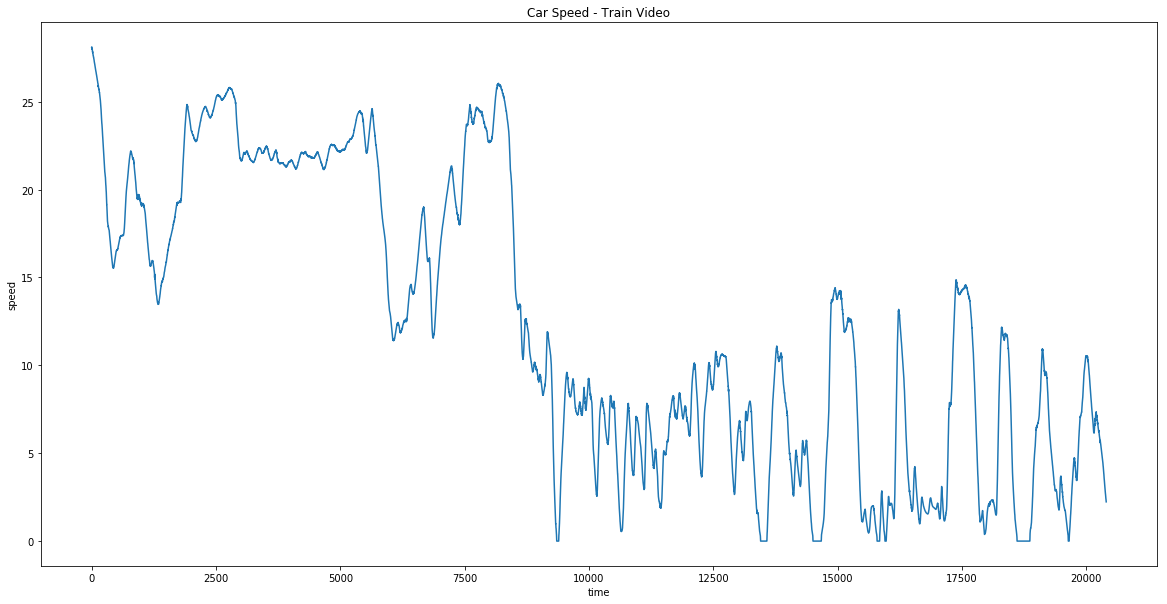

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(speeds_df)
plt.xlabel('time')
plt.ylabel('speed')
plt.title('Car Speed - Train Video')
plt.show()

### Cropping

Let's take a look at what we can remove from the image (sky, dashboard, etc.)

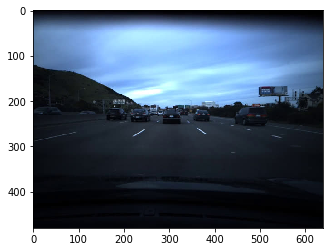

In [7]:
def custom_crop(image):
    cropped_image = image[80:350, ...]
    return cropped_image

crop_dummy = load_image(get_image_path(MAIN, 400))
plt.imshow(crop_dummy)

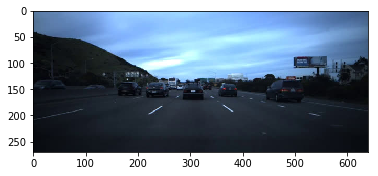

In [8]:
plt.imshow(custom_crop(crop_dummy))

### Testing Optical Flow

I want to try calculating dense optical flow in two methods:

1. Farneback Method
2. C. Liu. Method detailed in 

C. Liu. Beyond Pixels: Exploring New Representations and Applications for Motion Analysis. Doctoral Thesis. Massachusetts Institute of Technology. May 2009

In [9]:
def calculate_liu_optical_flow(img_1, img_2):
    alpha = 0.012
    ratio = 0.75
    minWidth = 20
    nOuterFPIterations = 7
    nInnerFPIterations = 1
    nSORIterations = 10
    colType = 0
    
    im_1 = np.array(img_1).astype(float) / 255.
    im_2 = np.array(img_2).astype(float) / 255.
    
    u, v, im2W = pyflow.coarse2fine_flow(
        im_1, im_2, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,
        nSORIterations, colType)
    
    hsv = np.zeros(img_2.shape, dtype=np.uint8)

    # take saturation values from second image
    #hsv[:, :, 1] = cv2.cvtColor(img_2, cv2.COLOR_RGB2HSV)[:,:,1]
    hsv[:, :, 1] = 255
    
    mag, ang = cv2.cartToPolar(u, v)

    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return rgb

def cartesian_farneback_optical_flow(image_current, image_next):
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    return flow

def calculate_farneback_optical_flow(image_current, image_next):
    hsv = np.zeros(image_next.shape, dtype=np.uint8)
    
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]

    # obtain dense optical flow paramters
    flow = cartesian_farneback_optical_flow(image_current, image_next) 

    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
    
    # hue corresponds to direction
    hsv[...,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to int32's
    #hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    
    return rgb_flow

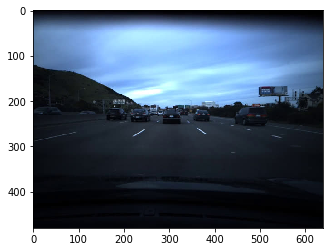

In [11]:
A = load_image(get_image_path(MAIN, 400))
B = load_image(get_image_path(MAIN, 401))
plt.imshow(A)

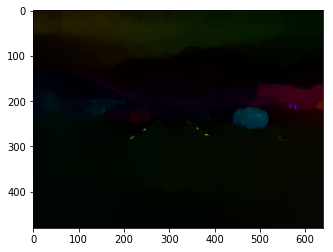

In [12]:
C = calculate_liu_optical_flow(A, B)
plt.imshow(C)

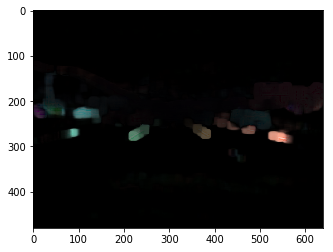

In [13]:
D = calculate_farneback_optical_flow(A, B)
plt.imshow(D)

The farneback method is much faster. On top of that, it looks like it's better at picking up flow vectors from static markers. These flow vectors are more important than those from noise like cars, etc. as there are more variables affecting the flow vectors of other moving objects than static markers. In fact, if we wanted to do better, we should find a way of identifying flow vectors from static objects & give more weight to those. 

We should also take some more knowledge of the real world and apply as that as a heuristic to filter noise. For instance, if the camera moves in space towards any point in the field of view then the flow vectors from static objects should all intersect at that point. 

A visual example:

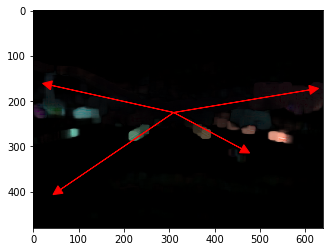

In [14]:
plt.imshow(D)
plt.arrow(310,225, -270, -60, color="red", head_width=20, head_length=20)
plt.arrow(310,225, 150, 80, color="red", head_width=20, head_length=20)
plt.arrow(310,225, -250, 170, color="red", head_width=20, head_length=20)
plt.arrow(310,225, 300, -50, color="red", head_width=20, head_length=20)

We would expect this kind of analysis to remove the vectors from the cars in the image. However, we don't always have this intersection in our field of view. Sometimes the car can be turning fast & the camera moves towards a point it does not have in its FOV. So, we would apply this heuristic with the appropriate precautions.

Before going deep into this, I'd like to have a baseline model & then apply this kind of analysis if it performs poorly. Let's start by creating our test & train data. 

In [15]:
DS_MEMO = {}
def distance_squared(slope, point, poi):
    key = np.array([slope, point, poi])
    key = key.flatten()
    key = tuple(key)
    try:
        return DS_MEMO[key]
    except:
        ds = (point - poi).T * (np.identity(2) -  slope * slope.T) * (point - poi)
        DS_MEMO[key] = ds
        return ds

def sum_distances_squared(lines, poi):
    D = np.sum([distance_squared(slope, point, poi) for slope, point in lines], 0)
    return D

def estimate_poi(lines):
    """
    We estimate the POI by taking the least squares solution to the intersection:
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf
    Input:
    lines = [(slope, point), (slope, point), ...]
    """
    R = np.sum([np.identity(2) - slope * slope.T for slope, point in lines], 0)
    q = np.sum([(np.identity(2) - slope * slope.T) * point  for slope, point in lines], 0)

    has_converged, poi = cv2.solve(R, q)
    
    error = sum_distances_squared(lines, poi)
    
    return poi, error

def setup_test_lines(given_poi):
    lines = []

    for x_i in range(20):
        for y_i in range(30):
            x = given_poi[0] - x_i
            y = given_poi[1] - y_i
            x_2 = np.square(x)
            y_2 = np.square(y)
            c_2 = x_2 + y_2
            c = np.sqrt(c_2)
            norm_x = x / c
            norm_y = y / c
            curr_n = np.matrix([norm_x, norm_y]).T
            curr_point = np.matrix([x_i, y_i]).T
            lines.append((curr_n, curr_point))
    
    return lines

In [16]:
TEST_POI = [100, 200]
test_lines = setup_test_lines(TEST_POI)
estimated_poi, error = estimate_poi(test_lines)
print(estimated_poi)
print(error)

[[100.]
 [200.]]
[[-2.80309109e-11]]


Awesome, it works. Now, let's add some noise & see what happens.

In [17]:
def setup_noisy_lines(num_points):
    lines = []

    for i in range(num_points):
        x_i = np.random.randint(0, 600)
        y_i = np.random.randint(0, 400)
        x = np.random.random()
        y = np.random.random()
        x_2 = np.square(x)
        y_2 = np.square(y)
        c_2 = x_2 + y_2
        c = np.sqrt(c_2)
        norm_x = x / c
        norm_y = y / c
        curr_n = np.matrix([norm_x, norm_y]).T
        curr_point = np.matrix([x_i, y_i]).T
        lines.append((curr_n, curr_point))
        
    return lines

test_poi = [100, 200]
test_lines = setup_test_lines(test_poi)
noisy_lines = setup_noisy_lines(10)
estimated_poi, error = estimate_poi(test_lines + noisy_lines)
print(estimated_poi)
print(error)

[[ 92.3668045 ]
 [182.31829964]]
[[151563.19788456]]


Unfortunately, it looks like the POI can be influenced quite a bit by noise. We can setup an error threshold & iteratively remove lines that have too high an error until we converge. By using max error instead of total error, we effectively create a circular neighbourhood from the estimated POI that all considered lines must pass through.

In [18]:
def partition_array(arr, sort_key, left_split):
    sorted_arr = sorted(arr, key = sort_key)
    split_index = int(len(arr) * left_split)
    left_arr = sorted_arr[:split_index]
    right_arr = sorted_arr[split_index:]
    return left_arr, right_arr

def iteratively_estimate_poi(lines, threshold, keep, max_iters):
    max_error = np.inf
    iterations = 0
    removed_lines = []
    
    while (max_error > threshold):
        if iterations > max_iters:
             return [], False, None
        curr_poi, error = estimate_poi(lines)
        lines, curr_removed_lines = partition_array(lines, lambda x: distance_squared(x[0], x[1], curr_poi), keep)
        removed_lines = removed_lines + curr_removed_lines
        max_error = distance_squared(lines[-1][0], lines[-1][1], curr_poi)
        iterations += 1
        
    return removed_lines, True, curr_poi

test_lines = setup_test_lines(test_poi)
noisy_lines = setup_noisy_lines(2)
rm_lines, converged, poi = iteratively_estimate_poi(test_lines + noisy_lines, 5, 0.99, 30)

print(len(test_lines + noisy_lines))
print(poi)
print(len(rm_lines))

602
[[100.]
 [200.]]
13


In [19]:
def generate_lines_from_flow(flow, mag_threshold):
    """
    Input: Cartesian flow
    Output: lines = [(slope, point), (slope, point), ...]
    """

    x = flow[..., 0]
    y = flow[..., 1]
    (num_x, num_y) = x.shape
    
    mag, ang = cv2.cartToPolar(x, y)

    x_2 = np.square(x)
    y_2 = np.square(y)

    c_2 = x_2 + y_2
    c = np.sqrt(c_2)
    norm_x = x / c
    norm_y = y / c
        
    lines = []
    
    for x_i in range(num_x):
        for y_i in range(num_y):
            if mag[x_i][y_i] > mag_threshold:
                n_1 = norm_x[x_i][y_i]
                n_2 = norm_y[x_i][y_i]
                curr_n = np.matrix([n_1, n_2]).T
                curr_point = np.matrix([x_i, y_i]).T
                lines.append((curr_n, curr_point))
    
    return lines

In [20]:
#D, _ = calculate_farneback_optical_flow(A, B)
#plt.imshow(D)
#plt.plot(poi[1], poi[0], marker='o', markersize=3, color="red")

Cool. Let's redefine our farneback optical flow function with this new filter. Hmm. I feel like setting the magnitude and angle to zero directly for the vectors we believe are noise may actually create more noise. Let's just try it anyways & see if any improvements happen to our model.

In [21]:
def calculate_farneback_optical_flow(image_current, image_next, poi_error=False, use_random_sampling=False):
    hsv = np.zeros(image_next.shape, dtype=np.uint8)
    
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]

    # obtain dense optical flow paramters
    flow = cartesian_farneback_optical_flow(image_current, image_next) 

    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
    
    num_x, num_y, num_z = flow.shape
    poi_errors = np.zeros((num_x, num_y), dtype=np.uint8)
    
    if poi_error:
        flow_lines = generate_lines_from_flow(flow, 0.5)
        if flow_lines:
            if use_random_sampling:
                # Arbitrarily remove 20% of the lines with the worst error from the POI generated by the sub sample above
                # Using all the flow vectors iteratively is too computationally expensive. So let's try this out and see how it performs.   
                flow_sample = np.random.choice(len(flow_lines), 50000)
                flow_sample = [flow_lines[i] for i in flow_sample]
                _, converged, poi = iteratively_estimate_poi(flow_sample, 50000, 0.80, 3)

            else:
                _, converged, poi = iteratively_estimate_poi(flow_lines, 50000, 0.80, 3)
            
            if converged:
                # create a matrix of errors
                for slope, point in flow_lines:
                    pt = np.squeeze(np.asarray(point))
                    x_coor = pt[0]
                    y_coor = pt[1]
                    poi_errors[x_coor][y_coor] = distance_squared(point, slope, poi)     
    
    # hue corresponds to direction
    hsv[...,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to int32's
    #hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    
    return rgb_flow, poi_errors

### Data -> Train / Validation / Evaluation

From the data for which we know the speeds, we will split it into training, validation, and evaluation data.

We will train the model on training, cross validate & tune with validation, and then finally evaluate performance on the evaluation set. 

We can randomly shuffle the available training frames into these three sets, but I don't think that's good enough. It's quite likely that most of the evaluation and validation sets will not be contigious. This means the model will have already seen small bits and pieces of very similar environments. I want to set aside about 30% of the validation & evaluation sets as continious frames. 

In [27]:
def split_dataset(df, split):
    continuous_train_df , continuous_test_df = train_test_split(df, test_size=0.05, shuffle=False, random_state=46)
    train_df, shuffle_test_df = train_test_split(continuous_train_df, test_size=split, random_state=46)
    
    test_df = pd.concat([shuffle_test_df, continuous_test_df])
    
    return train_df, test_df

train_df, evaluation_df = split_dataset(speeds_df, 0.10)
train_df, validation_df = split_dataset(train_df, 0.20)

# Sanity Check; this should give us the number of training points available
print(train_df.shape[0] + evaluation_df.shape[0] + validation_df.shape[0])

998


Now, we can process pairs of successive frames to build the train, validation, and evaluation sets. 
We will crop the frames, calculate optical flow, and resize the result to the input size of our neural network. 
The one difference that sets apart the train set is that pairs of images should be augmented by an illumination factor to regularize against brightness changes.

In [28]:
def custom_resize(image):
    resized_image = cv2.resize(image, (N_img_width, N_img_height), interpolation = cv2.INTER_AREA)
    return resized_image

def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

def construct_optical_flow_dataset(frames_df, dataset_folder, target_folder, augment_brightness_indices=[]):
    
    create_empty_folder(target_folder)
    
    for idx, row in tqdm_notebook(frames_df.iterrows(), total=frames_df.shape[0]):
        curr_img_path = get_image_path(dataset_folder, idx)
        preceding_img_path = get_image_path(dataset_folder, idx - 1)
        
        curr_img = load_image(curr_img_path)
        preceding_img = load_image(preceding_img_path)
        
        curr_img = custom_crop(curr_img)
        preceding_img = custom_crop(preceding_img)
        
        if idx in augment_brightness_indices:
            bright_factor = np.random.uniform(0,1.3)
            curr_img = change_brightness(curr_img, bright_factor)
            preceding_img = change_brightness(preceding_img, bright_factor)
           
        curr_img = custom_resize(curr_img)
        preceding_img = custom_resize(preceding_img)
        
        flow, poi_errors = calculate_farneback_optical_flow(preceding_img, curr_img, False)

        curr_flow_path = os.path.join(target_folder, str(idx) + '.npy')
        np.save(curr_flow_path, flow)

In [29]:
construct_optical_flow_dataset(speeds_df, MAIN, OPTICAL, train_df.index.values.tolist())

It's much faster to precompute the flow values and then use the generator below to feed training & validation samples to the neural net. The reason for this is because the network will reuse the same images many times, resulting in unneccessary recomputation of flow values. It's best to precompute all these, rather than have them in memory or generate them on the fly each time. 

In [30]:
def generate_samples(dataset_folder, df, batch_size=16):
    input_batch = np.zeros((batch_size, N_img_height, N_img_width, N_img_channels * WINDOW_SIZE))
    output_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            data_idx = np.random.randint(0, len(df) - 1)
            row = df.iloc[data_idx]
            flow = []
            # The window size is the number of consecutive optical flow frames to consider
            for j in range(WINDOW_SIZE):
                curr_flow_index = int(row.name) - j
                flow_path = os.path.join(dataset_folder, str(curr_flow_index) + '.npy')
                if os.path.exists(flow_path):
                    curr_flow = np.load(flow_path)
                    flow.append(curr_flow)
                else:
                    flow = flow + flow 
            try:
                input_batch[i] = np.stack(flow).reshape(N_img_height, N_img_width, N_img_channels * WINDOW_SIZE)
            except:
                print(data_idx)
                raise
            output_batch[i] = row['speed']

        yield (input_batch, output_batch)

## Model Training

Approach:
* Build a simple model: Input-> Convolution layers -> Flatten -> Dense layers -> 1 value
* Improve test MSE by adding layers, until it no longer improves
* Then prevent overfitting by adding dropout layers
* Test on eval set

Other things I tried:
* Test between ELU vs RELU (RELU wins for this task)
* Try to use more than 1 successive optical flow frame, this is the WINDOW_SIZE variable

In [31]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint

def cnn_model():
    inputShape = (N_img_height, N_img_width, N_img_channels * WINDOW_SIZE)

    model = Sequential()

    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape = inputShape))
    
    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            activation = 'relu',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            activation = 'relu',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    

    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            activation = 'relu',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))

    model.add(Dropout(0.3))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            activation = 'relu',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
                
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            activation = 'relu',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(Dense(100, kernel_initializer = 'he_normal', activation = 'relu',name = 'fc1'))
    model.add(Dense(50, kernel_initializer = 'he_normal', activation = 'relu', name = 'fc2'))
    model.add(Dense(10, kernel_initializer = 'he_normal', activation = 'relu', name = 'fc3'))
    
    model.add(Dense(1, activation="relu", name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

def load_model(weights_fp):
    model = cnn_model()
    model.load_weights(weights_fp)
    return model

WEIGHTS_FP = 'model-weights.h5'

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(WEIGHTS_FP, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
callbacks_list = [modelCheckpoint, earlyStopping]

model = cnn_model()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 120, 400, 6)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 198, 24)       3624      
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 97, 36)        21636     
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 47, 48)        43248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 47, 48)        0         
_________________________________________________________________
conv4 (Conv2D)               (None, 10, 45, 64)        27712     
_________________________________________________________________
conv5 (Conv2D)               (None, 8, 43, 64)         36928     
__________

In [32]:
train_generator = generate_samples(OPTICAL, train_df, 16)
validation_generator = generate_samples(OPTICAL, validation_df, 1)

history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 400, 
        epochs = 25,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = validation_generator,
        validation_steps = len(validation_df) - 1)

Epoch 1/25
400/400 [==============================] - 139s 346ms/step - loss: 12.9507 - val_loss: 38.5342

Epoch 00001: val_loss improved from inf to 38.53423, saving model to model-weights.h5
Epoch 2/25
400/400 [==============================] - 137s 344ms/step - loss: 6.0793 - val_loss: 23.8869

Epoch 00002: val_loss improved from 38.53423 to 23.88686, saving model to model-weights.h5
Epoch 3/25
400/400 [==============================] - 137s 343ms/step - loss: 5.5013 - val_loss: 17.3790

Epoch 00003: val_loss improved from 23.88686 to 17.37903, saving model to model-weights.h5
Epoch 4/25
400/400 [==============================] - 138s 344ms/step - loss: 5.1234 - val_loss: 11.2793

Epoch 00004: val_loss improved from 17.37903 to 11.27933, saving model to model-weights.h5
Epoch 5/25
400/400 [==============================] - 138s 345ms/step - loss: 4.9005 - val_loss: 9.8460

Epoch 00005: val_loss improved from 11.27933 to 9.84601, saving model to model-weights.h5
Epoch 6/25
400/400 [=

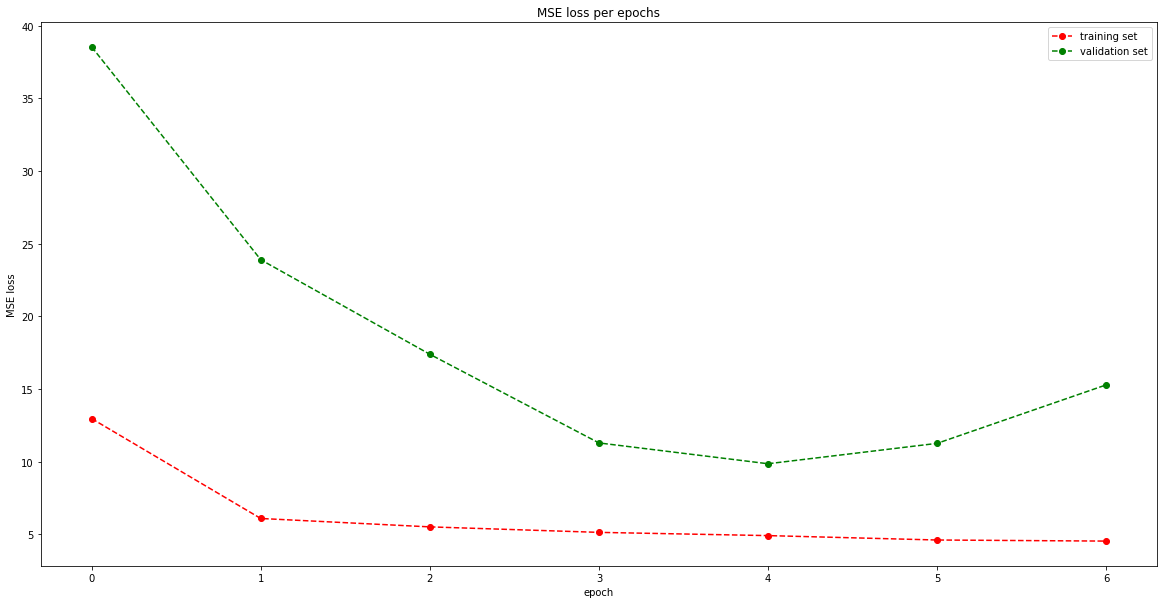

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history.history['loss'], 'ro--')
plt.plot(history.history['val_loss'], 'go--')
plt.title('MSE loss per epochs')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

## Model Evaluation

In [34]:
evaluation_generator = generate_samples(OPTICAL, evaluation_df, 1)
eval_score = model.evaluate_generator(evaluation_generator, steps= len(evaluation_df) - 1)
print(eval_score)

15.213861997989524


In [35]:
def make_predictions(model, video_fp, num_frames, folder_name):
    PREDICT = folder_name + "_predict"
    PREDICT_OPTICAL = PREDICT + "_optical"
    
    # split video into frames
    construct_dataset(video_fp, PREDICT, num_frames)
    
    predict_df = pd.DataFrame([], range(WINDOW_SIZE, num_frames), ['speed'])
    null_predict_df = pd.DataFrame([], range(0, WINDOW_SIZE), ['speed'])
    
    construct_optical_flow_dataset(predict_df, PREDICT, PREDICT_OPTICAL)
    
    for idx, row in predict_df.iterrows():
        flow_path = os.path.join(PREDICT_OPTICAL, str(idx) + '.npy')
        curr_flow = np.load(flow_path)
        prediction = model.predict(curr_flow)
        predict_df.at[idx, 'speed'] = prediction
    
    # add back indices for frames 0...WINDOW_SIZE, then backfill
    all_predictions = pd.concat([null_predict_df, predict_df])
    all_predictions.fillna(method='bfill', inplace=True)
    
    return all_predictions

In [36]:
#trained_model = load_model(WEIGHTS_FP)
#train_prediction = make_predictions(trained_model, VIDEO_FP, NUM_FRAMES, 'train')

In [37]:
#test_prediction = make_predictions(trained_model, VIDEO_FP, NUM_FRAMES, 'train')